In [261]:
import numpy as np
np.random.seed(2017)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
def hit():
    card = np.random.randint(1, 11)
    flag = np.random.choice([-1,1],size=1, p=[1/3, 2/3])
    return card * flag[0]

In [302]:
def step(state, action): # state: (player, dealer). action: {stick, hit} for player.
    player_score = state[0]
    dealer_score = state[1]
    if action == "hit":
        player_score += hit()
        if player_score > 21 or player_score < 1:
            return [0, 0], -1
        else:
            return [player_score, dealer_score], 0
    elif action == "stick":
        while dealer_score < 17:
            dealer_score += hit()
            if dealer_score < 1 or dealer_score > 21: return [0, 0], 1
        if dealer_score > player_score: return [0, 0], -1
        elif dealer_score == player_score: return [0, 0], 0
        else: return [0, 0], 1

In [303]:
def mc(episodes=100): # Monte Carlo control in easy21
    q_value = np.zeros(shape=(22, 11, 2))
    count = np.zeros(shape=(22, 11, 2))
    actions = ['stick', 'hit']
    terminal = [0, 0]
    N0 = 100
    for episode in range(episodes):
        E = []
        G = []
        s = [np.random.randint(1, 11),np.random.randint(1, 11)]
        while s != terminal: # one episode
            epsilon = N0 / (N0 + np.sum(count[s[0], s[1]]))
            if np.random.uniform() < epsilon:
                a = np.random.randint(0, 2)
            else:
                a = np.argmax(q_value[s[0], s[1]])
            count[s[0], s[1], a] += 1
            s_next, r = step(s, actions[a])
            E.append((s, a))
            G.append(r)
            s = s_next
        i = 0
#         print (list(zip(E, G)))
        for s, a in E:
            q_value[s[0], s[1], a] = q_value[s[0], s[1], a] + \
                                    (1.0 / count[s[0], s[1], a]) * (np.sum(G[i:])- q_value[s[0], s[1], a])
            i += 1
    return np.max(q_value, axis=2)[1:, 1:], q_value[1:, 1:]  

In [304]:
V, Q_real = mc(100000)

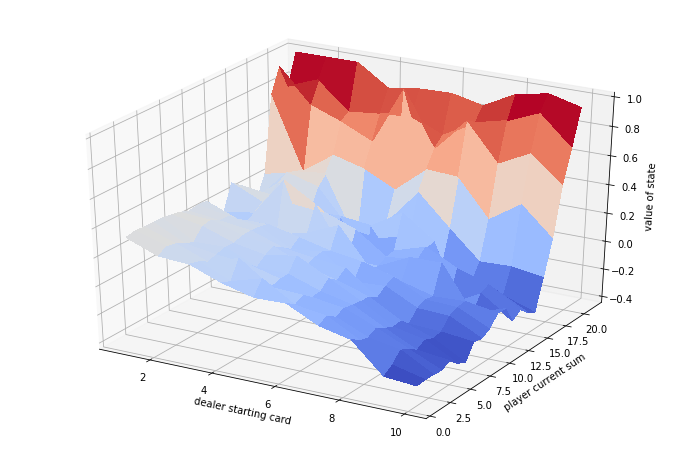

In [305]:
plt.rcParams['figure.figsize'] = (12, 8)
fig = plt.figure()
ha = fig.gca(projection='3d')
x = range(21)
y = range(10)
X, Y = np.meshgrid(y, x)
ha.plot_surface(X+1, Y+1, V, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
ha.set_xlabel("dealer starting card")
ha.set_ylabel("player current sum")
ha.set_zlabel("value of state")
plt.show()

In [290]:
def sarsa(l=0.1, episodes=10000):
    q_value = np.zeros(shape=(22, 11, 2))
    count = np.zeros(shape=(22, 11, 2))
    actions = ['stick', 'hit']
    terminal = [0, 0]
    N0 = 100
    tmp = list()
    for episode in range(episodes):
        eligibility = np.zeros(shape=(22, 11, 2))
        s = [np.random.randint(1, 11),np.random.randint(1, 11)]
        a = np.random.randint(0, 2)
        while s != terminal:
            count[s[0], s[1], a] += 1
            s_next, r = step(s, actions[a])
            epsilon = N0 / (N0 + np.sum(count[s[0], s[1]]))
            if np.random.uniform() < epsilon:
                a_next = np.random.randint(0, 2)
            else:
                a_next = np.argmax(q_value[s_next[0], s_next[1]])
            delta = r + q_value[s_next[0], s_next[1], a_next] - q_value[s[0], s[1], a]
            eligibility[s[0], s[1], a] += 1
            alpha = 1.0 / count[s[0], s[1], a]
            q_value += alpha * delta * eligibility
            eligibility *= l
            s = s_next
            a = a_next
        if episode % 100 == 0: tmp.append(np.mean((q_value[1:, 1:]-Q_real)**2))
    return np.max(q_value, axis=2)[1:, 1:], q_value[1:, 1:], tmp

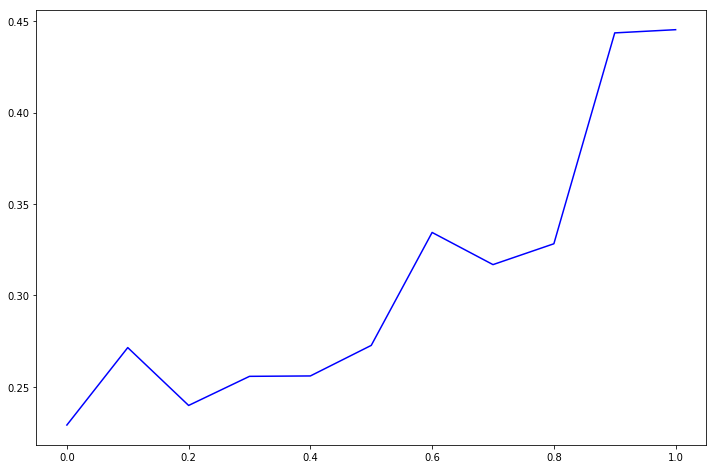

In [312]:
lambda_set = np.linspace(0, 1, 11)
x = []
y = []
history = list()
for item in lambda_set:
    V_sarsa, Q, tmp = sarsa(l=item, episodes=1000)
    x.append(item)
    y.append(np.mean((Q-Q_real)**2))
    history.append(tmp)
plt.plot(x, y, 'b')
plt.show()

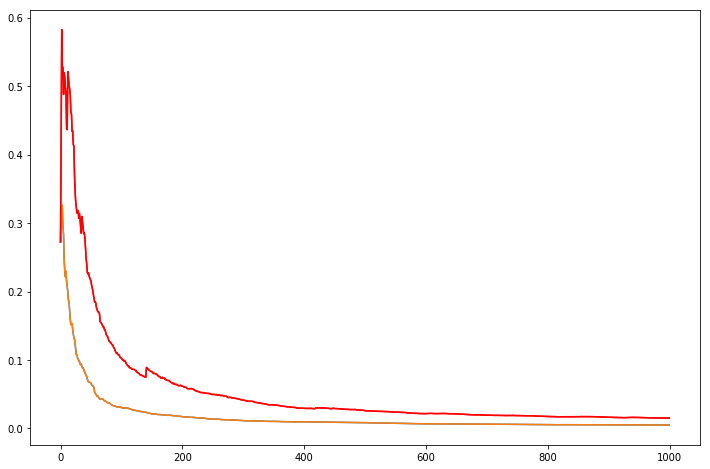

In [295]:
plt.plot(range(1000), history[0], range(1000), history[1], 'r')
plt.show()

In [175]:
def features(s, a):
    phi = np.zeros(shape=(6, 3, 2))
    player = [[1,6], [4, 9], [7, 12], [10, 15], [13, 18], [15, 21]]
    dealer = [[1,4], [4, 7], [7, 10]]
    p_index = []
    d_index = []
    for idx, p in enumerate(player):
        if s[0] >= p[0] and s[0] <= p[1]: p_index.append(idx)
    for idx, d in enumerate(dealer):
        if s[1] >= d[0] and s[1] <= d[1]: d_index.append(idx)
    
    for p in p_index:
        for d in d_index:
            phi[p, d, a] = 1
    return phi.flatten()        

In [308]:
def fa(l=0.1, episodes=1000):
    actions = ['stick', 'hit']
    terminal = [0, 0]
    w = np.random.randn(6*3*2)
    epsilon = 0.05
    alpha = 0.01
    for episode in range(episodes):
        E = np.zeros(6*3*2)
        s = [np.random.randint(1, 11),np.random.randint(1, 11)]
        a = np.random.randint(0, 2)
        while s != terminal:
#             idx, = np.where(features(s, a)==1)
#             E[idx] += 1
            s_next, r = step(s, actions[a])
            if np.random.uniform() < epsilon:
                a_next = np.random.randint(0, 2)
            else:
                a_next = 0 if features(s_next, 0).dot(w) > features(s_next, 1).dot(w) else 1
            delta = r + features(s_next, a_next).dot(w) - features(s, a).dot(w)
            E = l * E + features(s, a)
            w += alpha * delta * E
            s = s_next
            a = a_next
    Q_fa = np.zeros(shape=(22, 11, 2))
    for player in range(1, 22):
        for dealer in range(1, 11):
            for action in range(0, 2):
                Q_fa[player, dealer, action] = features([player, dealer], action).dot(w)

    Q_fa = Q_fa[1:, 1:]
    V_fa = np.max(Q_fa, axis=2)
    return Q_fa, V_fa

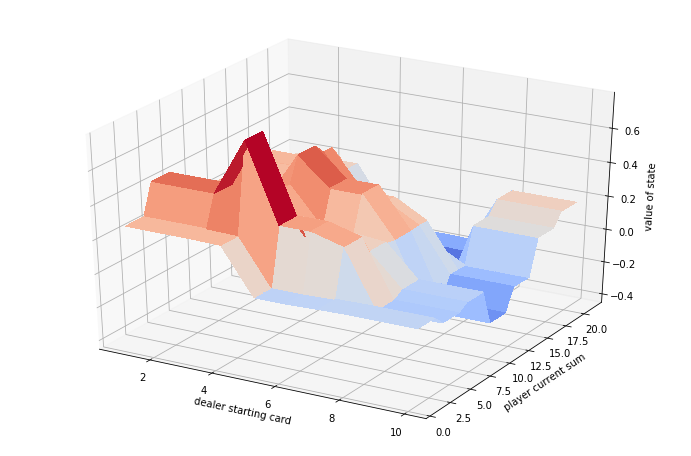

In [313]:
_, V_fa = fa(l=1, episodes=10000)

fig = plt.figure()
ha = fig.gca(projection='3d')
x = range(21)
y = range(10)
X, Y = np.meshgrid(y, x)
ha.plot_surface(X+1, Y+1, V_fa, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
ha.set_xlabel("dealer starting card")
ha.set_ylabel("player current sum")
ha.set_zlabel("value of state")
plt.show()

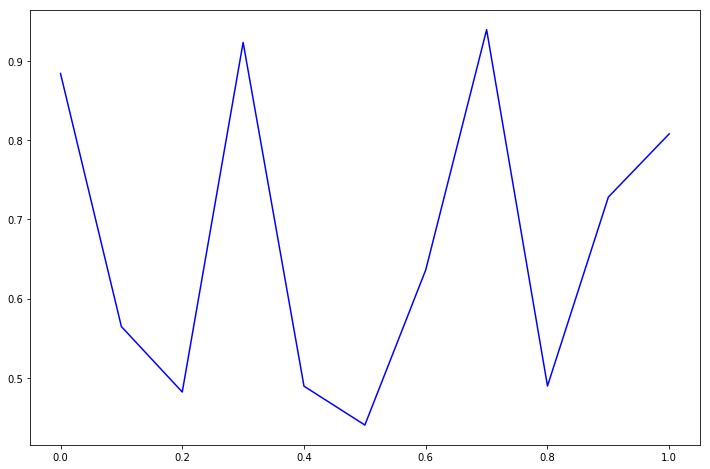

In [314]:
lambda_set = np.linspace(0, 1, 11)
x = []
y = []
for item in lambda_set:
    Q_fa, _ = fa(l=item)
    x.append(item)
    y.append(np.mean((Q_fa-Q_real)**2))

plt.plot(x, y, 'b')
plt.show()